In [1]:
%%time

import pandas as pd
import numpy as np

# Random seed for reproducibility
SEED = 123
# A file to save global variables
global_variables = pd.DataFrame({'SEED': [SEED]})
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

train_unprocessed = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_unprocessed = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK')

train_unprocessed.head()

CPU times: total: 844 ms
Wall time: 1.32 s


latitude  longitude  year  week_no  \
ID_LAT_LON_YEAR_WEEK                                           
ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0   
ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1   
ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2   
ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3   
ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4   

                          SulphurDioxide_SO2_column_number_density  \
ID_LAT_LON_YEAR_WEEK                                                 
ID_-0.510_29.290_2019_00                                 -0.000108   
ID_-0.510_29.290_2019_01                                  0.000021   
ID_-0.510_29.290_2019_02                                  0.000514   
ID_-0.510_29.290_2019_03                                       NaN   
ID_-0.510_29.290_2019_04                                 -0.000079   

                          SulphurDioxide_SO2_column_number_density_amf  \
ID_LAT_LON_YEAR_WEEK                                                     
ID_-0.510_29.290_2019_00                                      0.603019   
ID_-0.510_29.290_2019_01                                      0.728214   
ID_-0.510_29.290_2019_02                                      0.748199   
ID_-0.510_29.290_2019_03                                           NaN   
ID_-0.510_29.290_2019_04                                      0.676296   

                          SulphurDioxide_SO2_slant_column_number_density  \
ID_LAT_LON_YEAR_WEEK                                                       
ID_-0.510_29.290_2019_00                                       -0.000065   
ID_-0.510_29.290_2019_01                                        0.000014   
ID_-0.510_29.290_2019_02                                        0.000385   
ID_-0.510_29.290_2019_03                                             NaN   
ID_-0.510_29.290_2019_04                                       -0.000048   

                          SulphurDioxide_cloud_fraction  \
ID_LAT_LON_YEAR_WEEK                                      
ID_-0.510_29.290_2019_00                       0.255668   
ID_-0.510_29.290_2019_01                       0.130988   
ID_-0.510_29.290_2019_02                       0.110018   
ID_-0.510_29.290_2019_03                            NaN   
ID_-0.510_29.290_2019_04                       0.121164   

                          SulphurDioxide_sensor_azimuth_angle  \
ID_LAT_LON_YEAR_WEEK                                            
ID_-0.510_29.290_2019_00                           -98.593887   
ID_-0.510_29.290_2019_01                            16.592861   
ID_-0.510_29.290_2019_02                            72.795837   
ID_-0.510_29.290_2019_03                                  NaN   
ID_-0.510_29.290_2019_04                             4.121269   

                          SulphurDioxide_sensor_zenith_angle  ...  \
ID_LAT_LON_YEAR_WEEK                                          ...   
ID_-0.510_29.290_2019_00                           50.843559  ...   
ID_-0.510_29.290_2019_01                           39.137194  ...   
ID_-0.510_29.290_2019_02                           52.868816  ...   
ID_-0.510_29.290_2019_03                                 NaN  ...   
ID_-0.510_29.290_2019_04                           35.515587  ...   

                          Cloud_cloud_top_height  Cloud_cloud_base_pressure  \
ID_LAT_LON_YEAR_WEEK                                                          
ID_-0.510_29.290_2019_00             3664.436218               61085.809570   
ID_-0.510_29.290_2019_01             3651.190311               66969.478735   
ID_-0.510_29.290_2019_02             4216.986492               60068.894448   
ID_-0.510_29.290_2019_03             5228.507736               51064.547339   
ID_-0.510_29.290_2019_04             3980.598120               63751.125781   

                          Cloud_cloud_base_height  Cloud_cloud_optical_depth  \
ID_LAT_LON_YEAR_WEEK                          

In [2]:
train_unprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 no

## 00. Baseline

First, we'll make a baseline prediction, that all emissions are equal to the median emission of the training set. We'll calculate the Score of this prediction on the training set (for future cases, we'll calculate separately Train Score and Cross-validation Score).

Here is what we'll use to compare performances of our models:

Cross-val Score = (Average Cross-validation RMSE) + (1 Standard deviation of Cross-validation RMSE).

(we want to minimize this Score).

Score for this case will be just Train RMSE.

We'll save our intermediate results in DataFrame scores_df:

In [3]:
from sklearn.metrics import mean_squared_error

train_predictions_00 = pd.DataFrame([train_unprocessed['emission'].median()] * len(train_unprocessed), columns=['emission'])

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test RMSE': []})

score_00 = mean_squared_error(train_unprocessed['emission'], train_predictions_00['emission'], squared=False) - 0

scores_df.loc[0, 'Comment'] = 'Just median'
scores_df.loc[0, 'Train Score'] = score_00
scores_df.loc[0, 'Cross-val Score'] = np.nan
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0  Just median   148.806038              NaN        NaN

Now, we'll make a submission to Kaggle to see our Test RMSE. We won't use Test RMSE in making decisions, since we don't want to overfit to the visible testing data (unvisible part of the testing data will be used in calculating the final competition score) but we'll use Test RMSE to catch bugs in our Score calculations:

In [4]:
test_predictions_00 = pd.DataFrame([train_predictions_00['emission'].median()] * len(test_unprocessed), columns=['emission'])
submission_00 = pd.concat([pd.DataFrame(test_unprocessed.index, columns=['ID_LAT_LON_YEAR_WEEK']), test_predictions_00], axis=1)

submission_00.to_csv('submissions/submission_00.csv', index=False)

scores_df.loc[0, 'Test RMSE'] = 169.19374
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0  Just median   148.806038              NaN  169.19374

## Choosing number of cross-validation splits

We'll use LightGBM with n_estimators=10 as our first estimator. It is fast, efficient, doesn't require normalization and can handle missing values. Increasing n_estimators will improve performance, 

For calculating Score, I wrote get_score function, that is located in ['functions/get_score.py'](functions/get_score.py). This function takes a number of TimeSeriesSplit slits as one of its arguments. 

We want such number of splits that give us the best balance between bias and variance. For the sake of run time, the optimal number of splits calculation is done in a separate file: ['functions/n_splits.py'](functions/n_splits.py). We'll calculate scores among several different random states (all depend on the SEED, chosen at the beginning of this file).

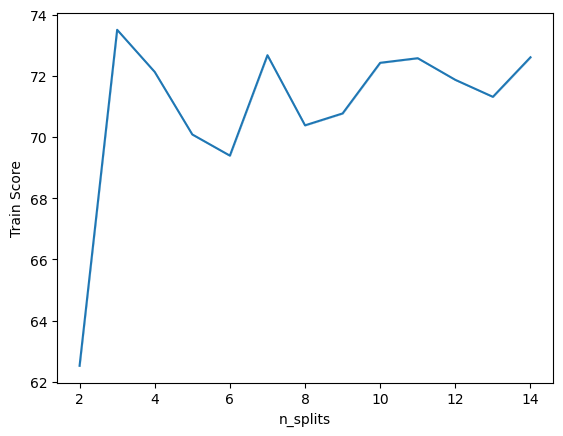

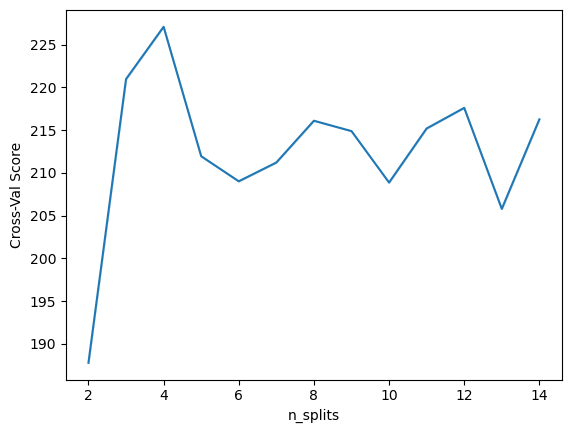

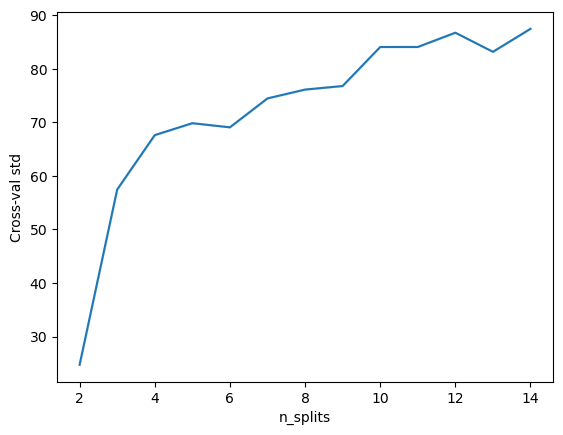

In [5]:
tradeoff = pd.read_csv('functions/tradeoff.csv', index_col=0)

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=tradeoff, x='n_splits', y='Train Score')
plt.show()
sns.lineplot(data=tradeoff, x='n_splits', y='Cross-Val Score')
plt.show()
sns.lineplot(data=tradeoff, x='n_splits', y='Cross-val std')
plt.show()


We'll use 4 splits, for a good balance between bias, variance and execution time:

In [6]:
N_SPLITS = 4
global_variables['N_SPLITS'] = N_SPLITS
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

## 01. LightGBM on unprocessed data

Let's find Scores and Test RMSE for this number of splits:

In [7]:
%%time

# UNCOMMENT TO INSTALL LightGBM
#!pip install lightgbm
import lightgbm as lgb

study_number = '01'

# Instantiate the estimator
model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1, n_estimators=10)

# Calculate scores
from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_unprocessed, test_unprocessed, model, scores_df,
                                                                  comment="LightGBM on unprocessed data")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

CPU times: total: 15 s
Wall time: 2.34 s


In [8]:
scores_df.loc[int(study_number), 'Test RMSE'] = 92.71815
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                   Just median   148.806038              NaN  169.19374
1  LightGBM on unprocessed data    72.130730       227.100652   92.71815

Good. Now we have a real baseline for comparing our models (based on the Cross-val Score).

## 02. Feature selection

However, time to train is still high on my laptop. Let's look at feature importances (according to our estimator) and select only the most important features:

In [9]:
%%time

study_number = '02'

## Train the model on the whole training set
model.fit(train_unprocessed.drop('emission', axis=1), train_unprocessed['emission'])

feature_importances = pd.Series(data=model.feature_importances_, index=train_unprocessed.drop('emission', axis=1).columns)

print('Sorted feature importances (first 10):')
feature_importances.sort_values(ascending=False).head(10)

Sorted feature importances (first 10):
CPU times: total: 2.22 s
Wall time: 343 ms


latitude                                  160
longitude                                 125
week_no                                    10
Cloud_solar_azimuth_angle                   1
UvAerosolIndex_solar_azimuth_angle          1
Formaldehyde_solar_azimuth_angle            1
Ozone_solar_azimuth_angle                   1
Cloud_surface_albedo                        1
UvAerosolIndex_absorbing_aerosol_index      0
UvAerosolIndex_sensor_altitude              0
dtype: int32

Now, let's select only features with non-zero feture importances and calculate the Score:

In [10]:
%%time

# Create copies of data
train = train_unprocessed.copy(deep=True)
test = test_unprocessed.copy(deep=True)

selected_columns = list(feature_importances.index[feature_importances > 0])
selected_columns

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]


#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected, test_selected,
                                                                   model, scores_df,
                                                                  comment="Only important features")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

CPU times: total: 3.98 s
Wall time: 388 ms


In [11]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                   Just median   148.806038              NaN  169.19374
1  LightGBM on unprocessed data    72.130730       227.100652   92.71815
2       Only important features    72.122560       227.045528        NaN

As we can see, Cross-val score has even decreased a bit, and speed is higher now.

There are many ways to proceed. I will be storing the ideas I haven't tried yet in ['ideas.txt'](ideas.txt).

## 03. Location Mean Target Encoding

Note, latitude and longitude do not really make sence as numerical features. Instead, we shall create a categorical feature Location, which will be a combination of latitude and longitude:

In [12]:
study_number = '03'

feature_name = 'Location'

# Create a new feature
for data in [train, test]:
    data[feature_name] = data['latitude'].astype('string') + data['longitude'].astype('string')
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())
    

<class 'pandas.core.series.Series'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: Location
Non-Null Count  Dtype 
--------------  ----- 
79023 non-null  string
dtypes: string(1)
memory usage: 3.2+ MB
None
count          79023
unique           497
top       -0.5129.29
freq             159
Name: Location, dtype: object
Unique Values and their count:
-0.5129.29      159
-0.72629.374    159
-0.54729.653    159
-0.56930.031    159
-0.59829.102    159
               ... 
-3.15330.347    159
-3.16128.839    159
-3.17429.926    159
-3.28729.713    159
-3.29930.301    159
Name: Location, Length: 497, dtype: Int64
<class 'pandas.core.series.Series'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Series name: Location
Non-Null Count  Dtype 
--------------  ----- 
24353 non-null  string
dtypes: string(1)
memory usage: 380.5+ KB
None
count          24353
unique           497
top       -0.5129.29
freq              49
Name: Locatio

Alright, we have 497 unique locations. We need to express Location as a numerical feature (or features). We'll create a feature Location_enc, using Mean Target Encoding, so locations with similar mean emissions (in the training set) will have similar Location_enc values.


In [13]:
# !pip install feature_engine

from feature_engine.encoding import MeanEncoder

encoder = MeanEncoder()

train['Location'] = train['Location'].astype('category')
test['Location'] = test['Location'].astype('category')

train['Location_enc'] = encoder.fit_transform(train[['Location']], train['emission'])
test['Location_enc'] = encoder.transform(test[['Location']])

feature_name = 'Location_enc'
for data in [train, test]:
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())
    

<class 'pandas.core.series.Series'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: Location_enc
Non-Null Count  Dtype  
--------------  -----  
79023 non-null  float64
dtypes: float64(1)
memory usage: 3.2+ MB
None
count    79023.000000
mean        81.940552
std        137.220332
min          0.000000
25%         10.900797
50%         46.700873
75%        113.135679
max       2233.431628
Name: Location_enc, dtype: float64
Unique Values and their count:
0.000000      2385
4.272966       159
102.257323     159
305.690542     159
336.199968     159
              ... 
42.203393      159
113.681664     159
67.246964      159
86.925462      159
27.633301      159
Name: Location_enc, Length: 483, dtype: int64
<class 'pandas.core.series.Series'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Series name: Location_enc
Non-Null Count  Dtype  
--------------  -----  
24353 non-null  float64
dtypes: float64(1)
memory usage: 380.5+

Now we have one feature for comparing locations. Let's remove longitude and latitude and add this feature instead:

In [14]:
%%time

selected_columns.remove('latitude')
selected_columns.remove('longitude')
selected_columns.append('Location_enc')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]

#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected, test_selected,
                                                                   model, scores_df,
                                                                  comment="Location_enc")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

CPU times: total: 3.39 s
Wall time: 398 ms


In [15]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                   Just median   148.806038              NaN  169.19374
1  LightGBM on unprocessed data    72.130730       227.100652   92.71815
2       Only important features    72.122560       227.045528        NaN
3                  Location_enc    55.455999       143.732975        NaN

Good, that worked, our Cross-val Score has decreased.

## 04. Week count

Even though 'year' variable wasn't selected by our model, we may still benefit from the better sence of time. For this, we'lll introduce WeekCount, which will be 0 for the first week in our time series, 1 for the next, and so on:

In [16]:
study_number = '04'

feature_name = 'WeekCount'
for data in [train, test]:
    
    data[feature_name] = (data['year'] - 2019) * 53 + data['week_no']
    
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())

train.tail()

<class 'pandas.core.series.Series'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: WeekCount
Non-Null Count  Dtype
--------------  -----
79023 non-null  int64
dtypes: int64(1)
memory usage: 3.2+ MB
None
count    79023.000000
mean        79.000000
std         45.898729
min          0.000000
25%         39.000000
50%         79.000000
75%        119.000000
max        158.000000
Name: WeekCount, dtype: float64
Unique Values and their count:
0      497
109    497
102    497
103    497
104    497
      ... 
54     497
55     497
56     497
57     497
158    497
Name: WeekCount, Length: 159, dtype: int64
<class 'pandas.core.series.Series'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Series name: WeekCount
Non-Null Count  Dtype
--------------  -----
24353 non-null  int64
dtypes: int64(1)
memory usage: 380.5+ KB
None
count    24353.000000
mean       183.000000
std         14.142426
min        159.000000
25%        171.0000

latitude  longitude  year  week_no  \
ID_LAT_LON_YEAR_WEEK                                           
ID_-3.299_30.301_2021_48    -3.299     30.301  2021       48   
ID_-3.299_30.301_2021_49    -3.299     30.301  2021       49   
ID_-3.299_30.301_2021_50    -3.299     30.301  2021       50   
ID_-3.299_30.301_2021_51    -3.299     30.301  2021       51   
ID_-3.299_30.301_2021_52    -3.299     30.301  2021       52   

                          SulphurDioxide_SO2_column_number_density  \
ID_LAT_LON_YEAR_WEEK                                                 
ID_-3.299_30.301_2021_48                                  0.000284   
ID_-3.299_30.301_2021_49                                  0.000083   
ID_-3.299_30.301_2021_50                                       NaN   
ID_-3.299_30.301_2021_51                                 -0.000034   
ID_-3.299_30.301_2021_52                                 -0.000091   

                          SulphurDioxide_SO2_column_number_density_amf  \
ID_LAT_LON_YEAR_WEEK                                                     
ID_-3.299_30.301_2021_48                                      1.195643   
ID_-3.299_30.301_2021_49                                      1.130868   
ID_-3.299_30.301_2021_50                                           NaN   
ID_-3.299_30.301_2021_51                                      0.879397   
ID_-3.299_30.301_2021_52                                      0.871951   

                          SulphurDioxide_SO2_slant_column_number_density  \
ID_LAT_LON_YEAR_WEEK                                                       
ID_-3.299_30.301_2021_48                                        0.000340   
ID_-3.299_30.301_2021_49                                        0.000063   
ID_-3.299_30.301_2021_50                                             NaN   
ID_-3.299_30.301_2021_51                                       -0.000028   
ID_-3.299_30.301_2021_52                                       -0.000079   

                          SulphurDioxide_cloud_fraction  \
ID_LAT_LON_YEAR_WEEK                                      
ID_-3.299_30.301_2021_48                       0.191313   
ID_-3.299_30.301_2021_49                       0.177222   
ID_-3.299_30.301_2021_50                            NaN   
ID_-3.299_30.301_2021_51                       0.184209   
ID_-3.299_30.301_2021_52                       0.000000   

                          SulphurDioxide_sensor_azimuth_angle  \
ID_LAT_LON_YEAR_WEEK                                            
ID_-3.299_30.301_2021_48                            72.820518   
ID_-3.299_30.301_2021_49                           -12.856753   
ID_-3.299_30.301_2021_50                                  NaN   
ID_-3.299_30.301_2021_51                          -100.344827   
ID_-3.299_30.301_2021_52                            76.825638   

                          SulphurDioxide_sensor_zenith_angle  ...  \
ID_LAT_LON_YEAR_WEEK                                          ...   
ID_-3.299_30.301_2021_48                           55.988022  ...   
ID_-3.299_30.301_2021_49                           19.435339  ...   
ID_-3.299_30.301_2021_50                                 NaN  ...   
ID_-3.299_30.301_2021_51                           32.599393  ...   
ID_-3.299_30.301_2021_52                            8.273742  ...   

                          Cloud_cloud_optical_depth  Cloud_surface_albedo  \
ID_LAT_LON_YEAR_WEEK                                                        
ID_-3.299_30.301_2021_48                  20.245954              0.304797   
ID_-3.299_30.301_2021_49                   6.104610              0.314015   
ID_-3.299_30.301_2021_50                  14.817885              0.288058   
ID_-3.299_30.301_2021_51                  32.594768              0.274047   
ID_-3.299_30.301_2021_52                  19.464032              0.226276   

                          Cloud_sensor_azimuth_angle  \
ID_LAT_LON_YEAR_WEEK                                   
ID_-3.299_30.301_2021_48    

Great. Now, let's test:

In [17]:
%%time

selected_columns.append('WeekCount')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]


#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected, test_selected,
                                                                   model, scores_df,
                                                                  comment="+ WeekCount")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

CPU times: total: 3.38 s
Wall time: 389 ms


In [18]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                   Just median   148.806038              NaN  169.19374
1  LightGBM on unprocessed data    72.130730       227.100652   92.71815
2       Only important features    72.122560       227.045528        NaN
3                  Location_enc    55.455999       143.732975        NaN
4                   + WeekCount    55.262555       143.765802        NaN

Since Cross-val Score increased, we won't use this feature:

In [19]:
selected_columns.remove('WeekCount')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]

## 05. Week of the year Mean Target Encoding

What if we do encoding on the 'week_no' feature? Potentially, it may catch some weekly common sesoanalities, if they exist.

In [20]:
study_number = '05'

from feature_engine.encoding import MeanEncoder

encoder = MeanEncoder()

train['week_no_category'] = train['week_no'].astype('category')
test['week_no_category'] = test['week_no'].astype('category')

train['week_no_enc'] = encoder.fit_transform(train[['week_no_category']], train['emission'])
test['week_no_enc'] = encoder.transform(test[['week_no_category']])

feature_name = 'week_no_enc'
for data in [train, test]:
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())
    

<class 'pandas.core.series.Series'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: week_no_enc
Non-Null Count  Dtype  
--------------  -----  
79023 non-null  float64
dtypes: float64(1)
memory usage: 3.2+ MB
None
count    79023.000000
mean        81.940552
std         11.358675
min         69.059198
25%         73.495496
50%         80.408753
75%         83.911750
max        115.211546
Name: week_no_enc, dtype: float64
Unique Values and their count:
72.088003     1491
73.000880     1491
72.415652     1491
70.403987     1491
75.116136     1491
75.136291     1491
74.912248     1491
75.988168     1491
79.200567     1491
79.366690     1491
79.985492     1491
80.843326     1491
86.388165     1491
103.587349    1491
106.899378    1491
110.402315    1491
115.211546    1491
81.144497     1491
81.831373     1491
82.322285     1491
83.484188     1491
81.286079     1491
80.913570     1491
81.764307     1491
76.659700     1491
72.845497     1491
73.344191  

Let's test:

In [21]:
%%time

selected_columns.append('week_no_enc')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]

#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected, test_selected,
                                                                   model, scores_df,
                                                                  comment="3 + week_no_enc")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

CPU times: total: 3.3 s
Wall time: 449 ms


In [22]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                   Just median   148.806038              NaN  169.19374
1  LightGBM on unprocessed data    72.130730       227.100652   92.71815
2       Only important features    72.122560       227.045528        NaN
3                  Location_enc    55.455999       143.732975        NaN
4                   + WeekCount    55.262555       143.765802        NaN
5               3 + week_no_enc    54.355940       143.466844        NaN

That worked.

## 06. Locaton AND Week of the year Mean Target Encoding

What if we combine Location and week_no in one categorical feature and try Mean Target Encoding?

In [23]:
study_number = '06'

train['Location+week_no'] = (train['Location'].astype('str') + train['week_no'].astype('str')).astype('category')
test['Location+week_no'] = (test['Location'].astype('str') + test['week_no'].astype('str')).astype('category')

train['Location+week_no_enc'] = encoder.fit_transform(train[['Location+week_no']], train['emission'])
test['Location+week_no_enc'] = encoder.transform(test[['Location+week_no']])

feature_name = 'Location+week_no'
for data in [train, test]:
    print(data[feature_name].info())
    print(data[feature_name].describe())
    print('Unique Values and their count:')
    print(data[feature_name].value_counts())
    

<class 'pandas.core.series.Series'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Series name: Location+week_no
Non-Null Count  Dtype   
--------------  -----   
79023 non-null  category
dtypes: category(1)
memory usage: 4.0+ MB
None
count           79023
unique          26341
top       -0.5129.290
freq                3
Name: Location+week_no, dtype: object
Unique Values and their count:
-0.5129.290       3
-2.26930.23121    3
-2.26930.23130    3
-2.26930.2313     3
-2.26930.23129    3
                 ..
-1.4930.5139      3
-1.4930.5138      3
-1.4930.5137      3
-1.4930.5136      3
-3.29930.3019     3
Name: Location+week_no, Length: 26341, dtype: int64
<class 'pandas.core.series.Series'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Series name: Location+week_no
Non-Null Count  Dtype   
--------------  -----   
24353 non-null  category
dtypes: category(1)
memory usage: 944.1+ KB
None
count           24353
unique          24353

In [24]:
%%time

selected_columns.append('Location+week_no_enc')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]

#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected, test_selected,
                                                                   model, scores_df,
                                                                  comment="+ Location+week_no_enc")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

CPU times: total: 3.91 s
Wall time: 453 ms


In [25]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                   Just median   148.806038              NaN  169.19374
1  LightGBM on unprocessed data    72.130730       227.100652   92.71815
2       Only important features    72.122560       227.045528        NaN
3                  Location_enc    55.455999       143.732975        NaN
4                   + WeekCount    55.262555       143.765802        NaN
5               3 + week_no_enc    54.355940       143.466844        NaN
6        + Location+week_no_enc    52.717994       140.844908        NaN

That worked as well.

## 07. Most important features revisited

We introduced several new features. Let's re-estimate what features are most important for calculating emission:

In [26]:
%%time

study_number = '07'

all_features = list(train_unprocessed.drop('emission', axis=1).columns)
all_features.append('Location_enc')
all_features.append('week_no_enc')
all_features.append('Location+week_no_enc')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]


## Train the model 
model.fit(train_selected.drop('emission', axis=1), train_unprocessed['emission'])

feature_importances = pd.Series(data=model.feature_importances_, index=train_selected.drop('emission', axis=1).columns)

print('Sorted feature importances (first 10):')
feature_importances.sort_values(ascending=False).head(10)

Sorted feature importances (first 10):
CPU times: total: 344 ms
Wall time: 84.3 ms


Location+week_no_enc                  215
week_no                                30
week_no_enc                            19
Cloud_surface_albedo                   17
Location_enc                           10
UvAerosolIndex_solar_azimuth_angle      5
Formaldehyde_solar_azimuth_angle        4
Ozone_solar_azimuth_angle               0
Cloud_solar_azimuth_angle               0
dtype: int32

In [27]:
%%time

selected_columns = list(feature_importances.index[feature_importances > 0])
print('Selected columns:')
print(selected_columns)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['emission']], axis=1)
test_selected =  test[selected_columns]


#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected, test_selected,
                                                                   model, scores_df,
                                                                  comment="Only important features revisited")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

Selected columns:
['week_no', 'Formaldehyde_solar_azimuth_angle', 'UvAerosolIndex_solar_azimuth_angle', 'Cloud_surface_albedo', 'Location_enc', 'week_no_enc', 'Location+week_no_enc']
CPU times: total: 3.8 s
Wall time: 363 ms


In [28]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                        Just median   148.806038              NaN  169.19374
1       LightGBM on unprocessed data    72.130730       227.100652   92.71815
2            Only important features    72.122560       227.045528        NaN
3                       Location_enc    55.455999       143.732975        NaN
4                        + WeekCount    55.262555       143.765802        NaN
5                    3 + week_no_enc    54.355940       143.466844        NaN
6             + Location+week_no_enc    52.717994       140.844908        NaN
7  Only important features revisited    52.722061       140.836780        NaN

## 08. Filling NaNs for 7 most important features

Let's use KNNImputer to input missing values for 7 most important features:

In [29]:
%%time

study_number = '08'

from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(weights='distance')
# fit on the dataset and transform the datasets
Xtrans = imputer.fit_transform(train_selected.drop('emission', axis=1))
#Xtrans = imputer.transform(train_selected.drop('emission', axis=1))
train_selected_filled = pd.DataFrame(Xtrans, index=train_selected.index)
train_selected_filled = pd.concat([train_selected_filled, train_selected['emission']], axis=1)
train_selected_filled.columns = train_selected.columns
Xtrans = imputer.transform(test_selected)
test_selected_filled = pd.DataFrame(Xtrans, index=test_selected.index, columns=test_selected.columns)


CPU times: total: 58.4 s
Wall time: 38.9 s


In [30]:
train_selected_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   week_no                             79023 non-null  float64
 1   Formaldehyde_solar_azimuth_angle    79023 non-null  float64
 2   UvAerosolIndex_solar_azimuth_angle  79023 non-null  float64
 3   Cloud_surface_albedo                79023 non-null  float64
 4   Location_enc                        79023 non-null  float64
 5   week_no_enc                         79023 non-null  float64
 6   Location+week_no_enc                79023 non-null  float64
 7   emission                            79023 non-null  float64
dtypes: float64(8)
memory usage: 7.4+ MB


In [31]:
#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected_filled, test_selected_filled,
                                                                   model, scores_df,
                                                                  comment="+ Filled")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

In [32]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                        Just median   148.806038              NaN  169.19374
1       LightGBM on unprocessed data    72.130730       227.100652   92.71815
2            Only important features    72.122560       227.045528        NaN
3                       Location_enc    55.455999       143.732975        NaN
4                        + WeekCount    55.262555       143.765802        NaN
5                    3 + week_no_enc    54.355940       143.466844        NaN
6             + Location+week_no_enc    52.717994       140.844908        NaN
7  Only important features revisited    52.722061       140.836780        NaN
8                           + Filled    52.722614       140.937285        NaN

This filling works worse than NaNs.

## 09. Filling NaNs based on 3 features

Now we'll use 3 most important features in calculating distances. They contain information about location and week of the year.

In [33]:
%%time

study_number = '09'

selected_columns_1 = list(feature_importances.sort_values(ascending=False).index[:3])
features_train = train[selected_columns_1]
features_test =  test[selected_columns_1]

# For each column with missing values
for column in list(train_selected.columns[train_selected.isna().any()]):
    
    # Create a DataFrame of a feature with missing values and 5 most important features
    df_to_fill_train = pd.concat([train[column], features_train], axis=1)
    df_to_fill_test = pd.concat([test[column], features_test], axis=1)
                                  
    # fit on the dataset
    imputer.fit(df_to_fill_train)
    # transform the datasets
    Xtrans = imputer.transform(df_to_fill_train)
    train_selected_filled[column] = Xtrans[:, 0]
    Xtrans = imputer.transform(df_to_fill_test)
    test_selected_filled[column] = Xtrans[:, 0]



CPU times: total: 1min 5s
Wall time: 38.3 s


In [34]:
train_selected_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   week_no                             79023 non-null  float64
 1   Formaldehyde_solar_azimuth_angle    79023 non-null  float64
 2   UvAerosolIndex_solar_azimuth_angle  79023 non-null  float64
 3   Cloud_surface_albedo                79023 non-null  float64
 4   Location_enc                        79023 non-null  float64
 5   week_no_enc                         79023 non-null  float64
 6   Location+week_no_enc                79023 non-null  float64
 7   emission                            79023 non-null  float64
dtypes: float64(8)
memory usage: 7.4+ MB


In [35]:
#Calculate scores
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_selected_filled, test_selected_filled,
                                                                   model, scores_df,
                                                                  comment="7 + Filled based on 3")

submission.to_csv('submissions/submission_' + study_number + '.csv', index=False)

In [36]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

Comment  Train Score  Cross-val Score  Test RMSE
0                        Just median   148.806038              NaN  169.19374
1       LightGBM on unprocessed data    72.130730       227.100652   92.71815
2            Only important features    72.122560       227.045528        NaN
3                       Location_enc    55.455999       143.732975        NaN
4                        + WeekCount    55.262555       143.765802        NaN
5                    3 + week_no_enc    54.355940       143.466844        NaN
6             + Location+week_no_enc    52.717994       140.844908        NaN
7  Only important features revisited    52.722061       140.836780        NaN
8                           + Filled    52.722614       140.937285        NaN
9              7 + Filled based on 3    52.743065       140.904253        NaN

That didn't work as well. Let's procced with unfilled data.

## 10. Number of estimators and learning rate

Let's look at how number of estimators and learning rate affect our results. We'll use all numeric parameters, except for WeekCount.

All the hyperparameters tuning will be done in separate files, for the sake of runtime.

In [42]:
study_number = '10'

train_selected = train.drop(['Location', 'week_no_category', 'Location+week_no', 'WeekCount'], axis=1)
test_selected = test.drop(['Location', 'week_no_category', 'Location+week_no', 'WeekCount'], axis=1)

train_selected.to_csv('new_datasets/train_1_10.csv')
test_selected.to_csv('new_datasets/test_1_10.csv')

In [43]:
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 78 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 no

## . LightGBM tuned

Let's do a hyperparameters tuning:

In [38]:
study_number = ''

# Save datasets
tra.to_csv('new_datasets/train_1_.csv')

In [44]:
# Instantiate the estimator
model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1, n_estimators=100)

# Calculate scores
from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train_unprocessed, test_unprocessed, model, scores_df,
                                                                  comment="test")
cross_score

254.3614113432966